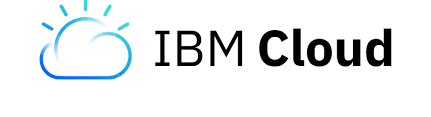

# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [ ]:
%%capture
pip install pyLDAvis

In [2]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline

DATA_DIR = os.path.join("..","data")

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Even before receiving the first comment, we want to start building our Pipeline using a proxy dataset. In this study Case we will work with a dataset publicly available dataset of movie reviews.

* [Here](http://www.nltk.org/nltk_data) is the web page that references all the public dataset that NLTK provide. In this Study Case we will work with the 'Sentiment Polarity Dataset Version 2.0' dataset. (The dataset has already been downloaded and is in the data folder of the working directory)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [ ]:
movie_reviews = load_files(os.path.join(DATA_DIR, "movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names
print(X[4])
print("\n")
print("target names {0}".format(target_names))

### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [ ]:
!spacy download en

In [ ]:
## Arreglar problema con modulo en que no carga en el jupyter env
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)
    doc = doc.replace('\\n','')
    doc = doc.replace('\\t','')

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

In [5]:
## YOUR CODE HERE

## Preprocess all the reviews of the corpus with the lemmatize_document() 
## function to create a list of cleaned reviews.

# from tqdm import tqdm
# tqdm.pandas()
# processed = df.progress_apply(lambda x : lemmatize_document(x['review'], STOPLIST), axis=1).tolist()

processed = ['barnold schwarzenegger icon action enthusiast late 80 lately pron sloppy oneliner bad pron hard seeing arnold mr freeze batman robin especially pron say ton ice joke hey pron 15 million pron matter pron arnold sign expensive blockbuster compare like terminator series true lie eraser dark thriller devil gabriel byrne come earth impregnate woman robin tunney happen 1000 year basically destroy world apparently god choose man man jericho cane arnold pron help trusty sidekick kevin pollack pron stop let devil world actually absurd pron fit right dogma yes weak pron blockbuster right sleepy hollow pron world look like star definitely like arnold pron just type pron pron sure pron pron chuckle pron known oneliner pron confused pron character pron understandable especially ending change accord source aside form pron walk pron like pron past pron sorry say arnold maybe end pron action day speaking action pron hardly explosion fight devil place explode arnold kick devil butt ending change pron spiritual undoubtedly ruin hope cool ending occur let know long cost really super affect unless pron consider invisible devil pron minute worth overpriced budget budget script audience somewhat entertain instead face boredom pron pitiful script like buy pron read thing anymore pron sure like pron thankfully gabriel performance light poor pron walk street search robin tunney pron help feel pron look like devil guy creepy look pron pron just glad pron end bother pron expect solid action flick pron solid pron action pron just pron suckere strategic marketing campaign save pron money world entertaining experience\n',
 '\n',
 '\n',
 '\n',
 'bgood hard day great rare proof life russell crowes onetwo punch deft kidnap rescue thriller rare gem taut drama lace strong subtle acting intelligent script masterful directing pron deliver virtually unheard industry day genuine motivation story ring true consider strange coincidence russell crowes character proof life distraught wife play meg ryans character real russell crowe hitch married woman meg ryan outside world chemistry actor mcqueen mcgraw team peckinpahs masterpiece getaway gossip let review revolve kidnapping peter bowman david morse american engineer work south america kidnap mass ambush civilian antigovernment soldier discover pron identity rebel soldier decide ransom pron million problem company peter bowman work auction step forward money choice available pron bowman wife alice ryan hire terry thorne crowe highly skilled negotiator rescue operative arrange return pron husband thing wrong pron situation terry pron team include surprising casting choice year david caruso matter pron hand notable pron simple story line create complex intelligent characterdriven vehicle wellwritten dialogue shade motivation convincing acting actor script base book long march freedom magazine article pertain kidnapransom situation story sharply piece tony gilroy screenwriter devil advocate dolore claiborne big surprise pron chemistry crowe ryan crowe david caruso dig bmovie hell caruso pull gutsy performance crowes right hand gun provide humor ryan lot smoke cigarette david morse end guerilla camp hate pron crowe provide memorable acting turn stoic gunslinger character terry thorne memorable piece lie pron action scene bulk scene bookend work extremely establishment closure device storys character scene skillfully craft execute amazing accuracy poise director taylor hackford mix pron oldschool style filmmake dizziness lars von tri proof life think mans action pron choice man woman face love war sacrifice choice sacrifice help pron sleep night\n',
 '\n',
 '\n',
 '\n',
 'bquaid star man proffesion dragonslayer pron feel pron betray dragon early pron run dragon existence genuinely amusing battle result standoff quaid dragon mouth pron sword point dragon brain eventually pron decide truce pron work deal pron dragon pron pretend die quaid able pay pron pron scam work pron come town money instead town sacrifice girl dragon course draco nice droagon pron eat pron amusing scene draco hit young girl course pron probably tell plot silly pron know pron seriously right times unlike eddie time pron probably medieval comedy laugh eddie spy hard combine dennis quaid fine hero pete posthlewaite provide ghreat comedy monk journey pron dina meyer appealing sacrifice girl let face pron really dragon amazing creation pron connerys voice ilm team provide pron truly magnificent dragon pron strong hard core medieval epic pron wrong pron dragon pron dissapointe pron provide plenty laugh smooth boring script\n',
 '\n',
 '\n',
 '\n',
 'bwe paraphrase michelle pfieffers character dangerous mind say rangoon start fair like school child benefit doubt chance succeed pron like think right combination talent effort wonder mountain good yeah right child fail director john boormans late success rangoon hinge believability patricia arquette ed wood true romance busty westernerinperil wander 1988 burma passport pron stomach mild plot contrivance pron pron tough task overlook actress pron lightweight scene narration demonstrate pron nearly range emotion pron charactera mother flee memory murder husband sonis suppose pron strong performance say keanu reeve walk cloud rangoon physically appealing thank practice craftsmanship john boorman deliverance excalibur hope glory pron narrative matter muddy storyor heroineget pron choose arquette remain mystery maybe pron think dramatic weight story overcome cast deficiencie hour halfstate political statement murky mass killing pron know happen country feel distressed character pron situation exoticism technical credit rangoon curious mix combine lush jungle photography bad bluescreen work odd obvious dubbing foreign character sound foreign pron pron mistake extra reappear different soldier doo doo doo doo twilight zone theme opinion pron judge\n',
 '\n',
 '\n',
 '\n',
 'bkolya rich pron time zdenek sverak play confirm old bachelor likely remain pron life czech cellist increasingly impact fiveyear old boy pron care pron end abruptly pron whine cause want spend time character act writing production value high high comparable american drama fatherandson delight sverak write script pron son jan direct win golden globe good foreign language couple day pron walk away oscar czech russian english subtitle\n',
 '\n',
 '\n',
 '\n',
 'bi know people idea cross pron mind pron life ongoing television watch world people pron use wonder young decide think pron watch lot tv pron brother hit pron head baseball bat pron pretty sure andrew niccol screenwriter truman curious thought truman man jim carrey entire life engineer corporation market public birth pron live fictional island town seahaven fla actually exist giant dome set just hollywood sign people truman burbank life actor anonymous townfolk pay extras people watch truman life 24 hour day live commercial interruption revenue come instead product placement staple contemporary hollywood truman friend relative pron consumer item cheerful optimistic tone sun rise set cue like pron truman pron probably learn crucial commercial trailer promotion blitz pron write far surprise pron pity pron pron primary source pron entertainment news way pron probably know premise truman pron pron probably think pron suck pron begin jim carrey look mirror recite crucial eat pron scene alive wish pron neighbor good day afternoon evening live domestic bliss pron wife laura linney weird thing start happen stage light come fall sky truman hear people track pron movement radio pron swear pron pron dead father pron learn flashback pron father drown truman child sailing rainstorm death stage director christof ed harris want fear water truman pron leave island similar cruel manipulation pron stumble truth pron truman good friend marlon noah emmerich assure pron pron conspiracy thing pron hurt pron truman trust eye tear christof fade emotional synthesizer music worldwide audience people apparently watch daily behindthescene update harry shearer capture highlight truman existence key like right balance humor drama premise like pron obvious implication direction pron hinge carrey balance comic naivet real sense longing drive hell pron come long way talk butt cheek ace ventura fundamentally pron just plain interesting follow director peter weir pron just pron capture person life person realize pron pron coordinate extra hide camera feed automatic line actor interesting thing truman pron probably imagine ambitious director pitch like sure interesting tv genre 90s reality programming jerry springer popularity roof people deserve humiliate turn pron intimate airwave news use hide camera pron great good entertainment merge pron truman right pron implausible mean fcc let pron say sword air pron think pron let pron broadcast mans life entire world pron consent day pron happen pron mean end privacy people eat pron pron know pron\n',
 '\n',
 '\n',
 '\n',
 'bcapsule trippy hyperspeed action machine hong kong accomplish tsui hark van damme rodman nice chemistry stunt eyepoppe stuff blow real good pron want admit set loathe double team pron reek cheapjack timingoriente market stick dennis rodman quick pron hot jeanclaude van damme flag career pron surprise double team transcend pron dumb root turn mess fun bring friend pretzel blast van damme jack quinn exagent bring mission pron think spy worth pron shoe phone run like hell pron hear word van dammes character pregnant wife sculptor unpleasant pressure use pron come mission pron assign old enemy terrorist stavros mickey rourke look oddly subdue pron old trick showdown quinn stavro wear pron ambition proudly pron sleeve nonstop action amusement park hospital private retire spy retreat rome various house plane car mode transport coliseum arena bonerattling shootout punchout pron reason jawdropping scene van damme man use switchblade pron foot van damme good dextrous athlete fighter pron upstaged nice touch stavro quinn want thing retire peace pron family ambition tie pron various way humanize pron bit thing hk action form human element carry pron weight scene forgettable good dennis rodman play weapon dealer yaz character stick like fistful broken finger funny just stand rodman natural screen pron fun watch especially sling bad guy like basketball deserve pron base lightweight fastmove entertainment showcase pron piece excellently\n',
 '\n',
 '\n',
 '\n',
 'bgothic murdermystery yarn new conceit fact pron book year proper handling pron come oldfashioned bland outdate gift direct sam raimi triedandtrue effort surprise little include wide array suspect red herring mansion deep south moss tree eventual discovery waterlogged corpse nearby pond pron fairly obvious killer fact predict pron begin correct pron preliminary suspicion ultimately work pron thank sparkling cast character memorable nuance fun simply watch people interact annie wilson cate blanchett recently widow mother son pron live psychic reading resident pron backwater southern hometown pron mainstay client include valerie barksdale hilary swank severely abuse pron husband donnie keanu reeves buddy cole giovanni ribisi unstable mechanic confuse nightmare pron mysterious blue diamond link pron father annie pron reading merely money use pron way seek solace good future pron late grandmother rosemary harris tell pron child pron gift pron pron remember annie eld son involve fight school pron meet niceguy school principal wayne collins greg kinnear pron pron attract wayne engage wealthy jessica king katie holmes annie immediately negative vibe party pron good friend linda kim dicken annie stumble jessica compromising position lawyer david duncan gary cole soon jessica disappear leave frenzy possibly happen pron annie start nightmare apparition link jessica vicious redneck donnie barksdale pond pron home gift cliche sheer storytelling level performance tight direction raimi redeem pron pron embarrassing 1999s love game lift picture notch slowly envelop viewer intriguing character pron individual plight disappearance jessica 30minute mark divulge true intention transform proceeding taut time frightening horrormystery center exceptional cate blanchett 1999s talented mr ripley turn annie wilson little runofthemill protagonist exact downtoearth realistic person valid trouble care attitude pron blanchett unextraordinary material run pron entire truly classy aura pron pron follow pron turn pron mesmerize character actress blanchett bright performer pron ably support good cast year pron role follow pron oscar win 1999s boy hilary swank excellent confused valerie seek guidance annie scared pron big advice leave grossly abusive donnie donnie keanu reeves 2000s watcher utterly convincing backwood meanie pron difficult believe pron actor oftencriticized reeve act ability good big compliment pron possibly pron performance pron giovanni ribisi 2000s boiler room heartbreake mentally slow young man annie pron friend want pron help pron understand pron plague bad dream pron dad small pivotal role sleazy jessica king katie holmes 2000s wonder boy turn stunning support turn pron promiscuous role jessica pron play pron radiant pron scene finally kim dickens 2000 hollow man pron usual strong impression annie spicy good friend linda notable aspect gift pron moody atmosphere lay thickly forebode air scene pron suffocate thank cleverly construe editing arthur coburn bob murawski successful use different eerie sound effect good music score christopher young achieve scary undercurrent dread help strong screenplay billy bob thornton tom epperson pron setting delightful cast gift rare thriller actually thrill offer fair share chills pron groundbreakingly original pron sure entertaining ride duration pron running time\n',
 '\n',
 '\n',
 '\n',
 'bwhat look necessarily perfection strong idea despite flaw pron prefer pron bettermade thoughtprovoking red line flawed pron provoke terence malick return filmmake 20 year day heaven produce meditative look war unlike year save private ryan dwell war necessary evil explore moral ambiguity thereof red line simply say war waste obvious experience pron realize profound waste pron save private ryan underlying practical acceptance war occur pron great cost red line say idealistically avoid cost message necessarily correct pron just depend point view malicks war set tropical paradise john tolls cinematography lush setting pose question pron fight face beauty save private ryan capture german soldier present moral quandary let pron red line japanese present moral quandary war place pron just like americans frighten angry grieving pray separate pron war flaw red line come voiceover unbelievable come character pretentious corny voiceover tell pron image pron completely unnecessary dispense pron malick achieve tarkovskian grandeur instead pron distract selfconsciousness aside malicks direction stunning tracking shot windswept hill transport speed shore extraordinary sean penn elias koteas nick nolte good performance penn subtle sergeant try hide pron humanism kotea genuine compassionate captain nolte startling colonel blood vessel burst pron win pron battle john travolta george clooney bad cameo role ultimately red line character pron drama pron frequently criticize pron lack dramatic structure malick clearly different thing pron mind think dramatic entertainment war exploitative malick work theme red line provoking\n',
 '\n',
 '\n',
 '\n',
 'bthe law crowd romantic state lead end end pron familiar law maybe pron trailer lead end pron regular reader pron hear pron say countless time pron know drive pron crazy end journey end worth pron pron definitely melissa joan hart abcs sabrina teenage witch like hunky stud basketball team adrien grenier pron grungy neighbor just break pron activist girlfriend apparently pron want pron exgirlfriend jealous pron pron want pron big year end dance pretend date reason hart grenier bath turn pron hunky stud grenier like pron new popularity turn pron friend crazy scheme work care teen comedy resurgence late surprisingly good term comedy like hardly wait 10 thing hate pron work extent pron kiss writer realize high school joke write pron script accordingly know writer intention drive pron crazy smart comedy obvious ending worth just teen whine pron big dance pron favor kid job just shut hell honesty good end credit normally say pron follow joke finally case end credit really entertaining obligatory second playing britney spears titular song quick commercial jingle burger joint kid hang brief rendition school song pron high school great entertaining 90 minute precede pron scifi fan note brief appearance stephen collins star trek motion picture faye grant tv miniserie final battle pg13\n',
 '\n',
 '\n',
 '\n',
 'bit ironic good cinema history invariably original director cut alien abyss wild bunch blade runner terminator prime example filmmaker integrity later chop muck studio advent dvd format provide accessible way original cut public provide freak like pron ability enrapture extension classic dvd release original international version luc bessons 1995 masterpiece professional know world prime example good instant classic director cut year hear international version available laserdisc format elude pron year buy laserdisc player pron uncle don 100 buck just watch certain director cut include countless search laserdisc store pron follow story play jean reno professional hit man italian mob crew run danny aiello pron live door ferociously independent 12yearold girl mathilda play newcomer natalie portman father involve drug crooked cop day crew cop lead gary oldman overthetop performance kill pron entire family mathilda buy grocery pity pron hide pron pron apartment pron return save pron life mathilda learn ons hit man profession decide follow ons footstep cleaner pron fall love pron manage reawaken emotion pron lock away pron profession point difference american version international version really kick international version contain additional 24 minute footage pertain directly relationship mathilda footage american censors deem explicit assume american censor feel define character development american audience handle good extra footage understanding mathilda ons motivation pertain later action involve oldman pron crew bad cop previously unseen cameo great french actor jeanhugues anglade star queen margot besson la femme nikita kill zoe additional scene replace matildas relationship bring pron emotionally close draw strong bond character murky american version ironic thing international version inclusion miss scene primarily heavy emotional drama punctuate big action scene beginning end better reflect drama french cinema lace piece reflect brutality american cinema pron advice throw away pron copy professional throw buck pick newly restore cinematic masterpiece directorwriter luc besson producer luc besson claude besson star jean reno natalie portman gary oldman danny aiello\n']

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the documents.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 500.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [6]:
## YOUR CODE HERE

max_features = 500

# Create a CountVectorizer object
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=max_features, stop_words='english')

# Fit and transform this object to the processed reviews
tf = tf_vectorizer.fit_transform(processed)
print("ready")

ready


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### QUESTION 3

Fit a LDA model to the corpus. For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```


* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [7]:
## YOUR CODE HERE
n_topics = 10

lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

# Fit the model to the bag of word we created earlier
lda_model.fit(tf)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [8]:
## YOUR CODE HERE
pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, R=20)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.053600 -0.000004       1        1  98.361609
3     -0.014978  0.000114       2        1   1.003222
6      0.006916 -0.001500       3        1   0.079396
8      0.007945 -0.000266       4        1   0.079396
4      0.009267 -0.000163       5        1   0.079396
7      0.008912  0.000302       6        1   0.079396
2      0.008570  0.000728       7        1   0.079396
0      0.009699 -0.000254       8        1   0.079396
1      0.008651  0.000792       9        1   0.079396
5      0.008619  0.000251      10        1   0.079396, topic_info=          Term        Freq       Total Category  logprob  loglift
191       pron  198.000000  198.000000  Default  20.0000  20.0000
139       like   14.000000   14.000000  Default  19.0000  19.0000
97        good   13.000000   13.000000  Default  18.0000  18.0000
34   character   12.000000   12.000000  Default  17.0000  17.0000
70         end   10.000000   10.000000  Default  16.0000  16.0000
..         ...         ...         ...      ...      ...      ...
92      friend    0.004789    6.188750  Topic10  -5.4271  -0.0258
184       play    0.004600    5.998300  Topic10  -5.4673  -0.0348
243      thing    0.004613    7.778865  Topic10  -5.4644  -0.2918
18         bad    0.004533    5.581683  Topic10  -5.4818   0.0227
206        run    0.004474    4.569576  Topic10  -5.4950   0.2097

[392 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  1.069565       24
2         1  1.004475  achieve
3         1  0.881673      act
4         1  0.948965   action
5         1  1.035388    actor
...     ...       ...      ...
270       1  0.936122    worth
271       1  1.041783    write
272       1  0.876858    wrong
273       1  1.003435     year
274       1  0.888748    young

[186 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 7, 9, 5, 8, 3, 1, 2, 6])

## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [12]:
## YOUR CODE HERE

# set the number of topics
n_topics = 7

# Create the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)
# fit and transform the LDA model to the vecotrized corpus

lda_model.fit(tf)
lda_transformed = lda_model.transform(tf)

# use the pyLDAvis to visualise the topics
pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, R=20)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.053504  0.000006       1        1  99.317866
6     -0.002246 -0.000274       2        1   0.113716
2     -0.008546  0.000544       3        1   0.113686
4     -0.010835 -0.001077       4        1   0.113684
0     -0.011527 -0.000141       5        1   0.113683
1     -0.010195  0.001059       6        1   0.113683
5     -0.010156 -0.000118       7        1   0.113682, topic_info=          Term        Freq       Total Category  logprob  loglift
191       pron  207.000000  207.000000  Default  20.0000  20.0000
139       like   15.000000   15.000000  Default  19.0000  19.0000
97        good   14.000000   14.000000  Default  18.0000  18.0000
34   character   12.000000   12.000000  Default  17.0000  17.0000
70         end   11.000000   11.000000  Default  16.0000  16.0000
..         ...         ...         ...      ...      ...      ...
184       play    0.006587    5.859841   Topic7  -5.4671  -0.0112
243      thing    0.006597    8.142356   Topic7  -5.4657  -0.3388
18         bad    0.006486    5.397334   Topic7  -5.4826   0.0555
133      leave    0.006408    3.818641   Topic7  -5.4947   0.3894
206        run    0.006402    4.426819   Topic7  -5.4957   0.2407

[258 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  1.000326       24
2         1  0.975190  achieve
3         1  0.951579      act
4         1  1.043202   action
5         1  1.029156    actor
...     ...       ...      ...
270       1  1.094661    worth
271       1  1.097362    write
272       1  1.015879    wrong
273       1  1.036090     year
274       1  0.918164    young

[150 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 3, 5, 1, 2, 6])

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

In [13]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Use the function to print the top k words for each topic

In [15]:
## YOUR CODE HERE

## set n_top_words
top_words = 15

## get the vectorizer's feature names
tf_feature_names = np.array(tf_vectorizer.get_feature_names())

## get the top words for each topic
top_words = get_top_words(lda_model, tf_feature_names, top_words)
all_top_words = np.array(list(set().union(*[v for v in top_words.values()])))

## print the topics and the top words of each topic
for key,vals in top_words.items():
    print(key, " ".join(vals))
print("total words: %s"%len(all_top_words))

0 whine new aside journey hinge money memorable follow direction achieve ending 24 sword tell family
1 actor lie hinge think probably really spy bad turn lush pity town motivation time wrong
2 think search pron red murky ryan woman nice wrong hinge love base john peter notable
3 pron like good character end scene just action life work thing man people know day
4 direction idea actually script truly entertainment worth girl act lot leave quick family write actor
5 friend genuine engineer big away include minute apparently theme thing play memorable real filmmake bad
6 pron war line red year finally american ryan emotion say character battle mass save keanu
total words: 90


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## QUESTION (EXTRA CREDIT) 7

If you used `transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects this matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


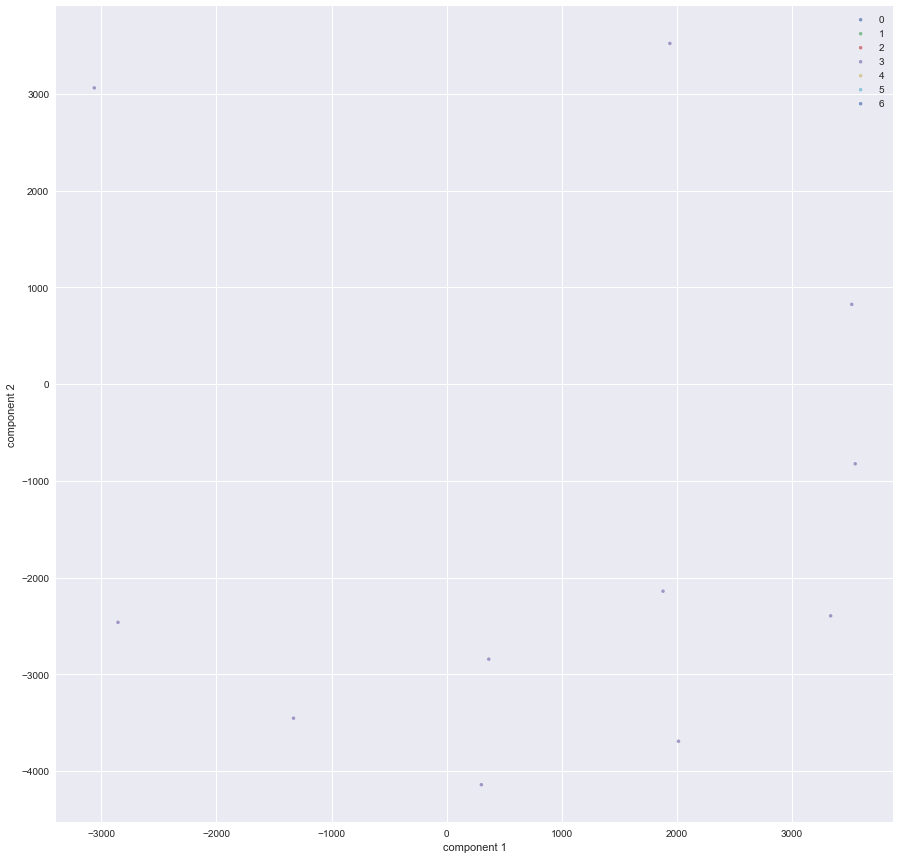

In [16]:
## YOUR CODE HERE
def make_plot(lda_mat):
    fig = plt.figure(figsize=(15, 15), facecolor='white')
    ax = fig.add_subplot(111)
    
    tsne = TSNE(n_components=2, perplexity=10, init='pca')
    projected = tsne.fit_transform(lda_mat)
    
    for class_num in np.arange(n_topics):
        topic_inds = np.where(lda_mat[:, class_num] > 0.5)[0]
        ax.scatter(projected[topic_inds, 0],
                   projected[topic_inds, 1], 
                   edgecolor='none', marker='.', alpha=0.7, label=str(class_num))
        
        ax.set_xlabel('component 1')
        ax.set_ylabel('component 2')
        ax.legend()
        
make_plot(lda_transformed)